# 1. 전달받은 데이터 확인 및 pdf에서 이미지로전환하기

In [3]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image
import datetime 
import math
import shutil

In [4]:
sourceTarget = "D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins"
arrNumbers = [
        7734,7758,7789,7802,7826,7857,7888,7932,7949,7963,7970,7994,8014,8038,9110,
        9189,9202,9233,9240,9257,9264,9288,9295,9301,
    ]
for number in arrNumbers:
    print( os.path.join(sourceTarget,"mutool.exe draw -r 144 -o ") + 
           os.path.join(sourceTarget, str(number)) + "_%d.jpg " + "{}.pdf".format( os.path.join(sourceTarget, str(number)) )  )

D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\mutool.exe draw -r 144 -o D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7734_%d.jpg D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7734.pdf
D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\mutool.exe draw -r 144 -o D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7758_%d.jpg D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7758.pdf
D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\mutool.exe draw -r 144 -o D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7789_%d.jpg D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7789.pdf
D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\mutool.exe draw -r 144 -o D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7802_%d.jpg D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7802.pdf
D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\mutool.exe draw -r 144 -o D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins\7826_%d.jpg D:\M

In [ ]:
!dir "D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins"

# 2. 변환된 이미지를 기반으로 Data Augmentation 진행하기

In [ ]:
def makeSampleImages(localfile, target_dir, looping_count):
    #print("localfile", localfile)
    #print("target_dir", target_dir)
    # 참고 사이트 
    # https://github.com/aleju/imgaug
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values
    # _per channel_.
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45), # rotate by -45 to +45 degrees
                shear=(-16, 16), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                    ]),
                    iaa.Invert(0.05, per_channel=True), # invert color channels
                    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.5, 1.5), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-4, 0),
                            first=iaa.Multiply((0.5, 1.5), per_channel=True),
                            second=iaa.ContrastNormalization((0.5, 2.0))
                        )
                    ]),
                    iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )    

    # 1. 먼저 데이터불러와서 만들어주기. : arrimages --> sourceimages
    arrimages = []        
    img = Image.open(localfile)
    npimage = np.array(img)            
    arrimages.append( npimage )        

    if len(arrimages) <= 0:
        raise ValueError("can't find the right image for the path.")

    firstimage = arrimages[0]
    for x in range( len(arrimages) -1):
        print("x", x, "firstimage.shape", firstimage.shape, "arrimages[x+1]", arrimages[x+1].shape)        
        if not np.array_equal( firstimage.shape, arrimages[x+1].shape ):
            raise ValueError("shape is not equals.\nPlz make the arrays equally distributed.")
    
    if not os.path.exists( target_dir ) :
        os.makedirs(target_dir)
    
    sourceimages = np.array(arrimages).reshape(-1, *arrimages[0].shape )    

    # 2. 변환된 데이터를 지정된 폴더에 저장하기.    
    prefix = datetime.datetime.now().strftime('%m%d%H%M%S')
    for rowindex in range(looping_count):
        images_aug = seq.augment_images( sourceimages )        
        for colindex in range( len(arrimages) ):
            Image.fromarray( images_aug[colindex] ).save(target_dir + "/{}_{}_{}.jpg".format(prefix, rowindex, colindex))

In [ ]:
for ind in arrNumbers:
        #local = sourcedir + str(ind)
        localfiles = glob.glob(sourceTarget + "/*.jpg")
        for localfile in localfiles:
            print("localfile", localfile)
            arrLocalfile = localfile.split("\\")
            
            folder = arrLocalfile[0]
            filename = arrLocalfile[-1]
            arrfilenames = filename.split(".")            
            
            #print("arrfilenames[0]", arrfilenames[0])
            #print( sourceTarget + "/" + arrfilenames[0] )
            os.makedirs( sourceTarget + "/" + arrfilenames[0] )
            makeSampleImages( localfile , sourceTarget + "/" + arrfilenames[0] , 100)
        print("folder is done : ", ind)

# 3. 만들어진 이미지 폴더확인하기

In [17]:
def plotCurrentFolderImages(targetfolder, cols):    
    files = glob.glob( os.path.join( targetfolder, "*.jpg") )   
    maxcount = len(files)
    
    #maxcount = 20
    #cols = 4
    rows = math.ceil( maxcount / cols )
    fig, axs = plt.subplots(rows, cols, figsize=(24 * 0.2 ,5 * rows * 0.2 ) , gridspec_kw = {'wspace':0, 'hspace':0} )
    #fig.tight_layout(pad = 0)
    for row in range(rows):
        for col in range(cols):
            nLocal = row * cols + col        
            axs[row, col].set( xticks=[], yticks=[], aspect=1)
            axs[row, col].tick_params(labelbottom=False, labelleft=False)
            if nLocal >= maxcount:
                continue                
            axs[row, col].imshow( Image.open( files[nLocal]) )
       

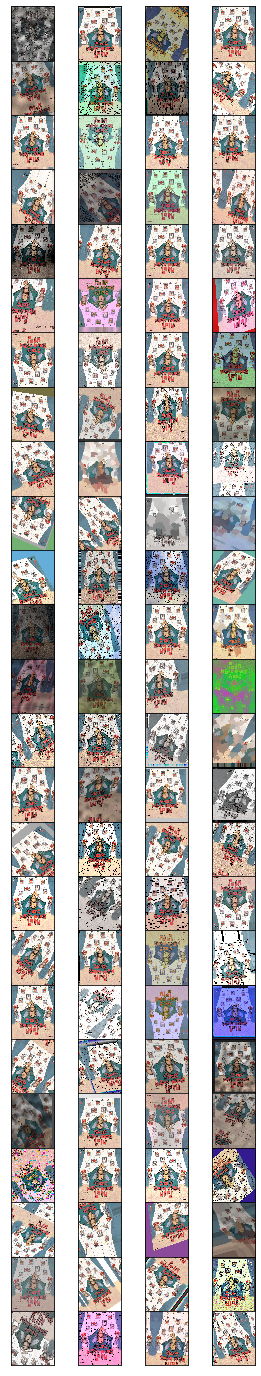

In [18]:
plotCurrentFolderImages('D:/MyProject/PyTorch/InterBookRec/datas/mylocalorigins/7734_1', 4)

# 4. 만들어진 이미지 데이터를 기준으로 Data Split하기

In [ ]:
def datasplit():
    originPath = 'D:\MyProject\PyTorch\InterBookRec\datas\mylocalorigins'
    targetPath = 'D:\MyProject\PyTorch\InterBookRec\datas\mylocaltarget'

    train_ratio = 0.8
    val_ratio = 0.1
    #test_ratio = 1 - train_ratio - val_ratio

    arrayOriginPaths = []

    globOriginPath = glob.glob( os.path.join( originPath, "*" ) )
    for item in globOriginPath:
        if os.path.isdir( item ):
            localDict = {}
            localDict[ "path" ] = item
            #print("item", item)
            localDict[ "data" ] = []
            arrayOriginPaths.append( localDict )            
            for jpgfile in glob.glob(os.path.join( item, "*.jpg")) :
                if os.path.isfile( jpgfile) :
                    localDict[ "data" ].append( jpgfile )
                    #print("jpgfile", jpgfile)

#     for item in arrayOriginPaths:
#         print("item.path", item["path"])
#         for jpgfile in item["data"]:
#             print("jpgfile", jpgfile)
    
    # 0.8, 0.1, 0.1
    # train = len * 0.8
    # val = len * 0.1
    # test = len * 0.1 
    trainPath = os.path.join(targetPath, "train")
    valPath = os.path.join(targetPath, "val")
    testPath = os.path.join(targetPath, "test")

    #print("trainPath", trainPath)
    if not os.path.exists( trainPath ): os.makedirs( trainPath )
    if not os.path.exists( valPath ): os.makedirs( valPath )
    if not os.path.exists( testPath ): os.makedirs( testPath )

    for item in arrayOriginPaths:
        #print("item.path", item["path"])
        trainLocalP = item["path"].replace( originPath, trainPath )
        valLocalP = item["path"].replace( originPath, valPath )
        testLocalP = item["path"].replace( originPath, testPath )
        
        #print("trainLocalP", trainLocalP)
        if not os.path.exists( trainLocalP ): os.makedirs( trainLocalP )
        if not os.path.exists( valLocalP ): os.makedirs( valLocalP )
        if not os.path.exists( testLocalP ): os.makedirs( testLocalP )

        

        #print(len( item["data"]) )
        itemlen = len( item["data"] )
        indextable = np.random.permutation(itemlen)
        train_max = math.floor( itemlen * train_ratio )
        val_max = math.floor( itemlen * (train_ratio + val_ratio) )
        #print("indextable", indextable)
        #print("train_max={}, val_max={}".format(train_max, val_max) )
        # train data process
        #print("move to train", "-------------" * 10)

        for ind in range(0, train_max):
            fileOriginalPath = item["data"][ indextable[ind] ]
            finalTargetPath = fileOriginalPath.replace( originPath, trainPath)
            #print("finalOriginalPath={}, to finalTargetPath={}".format( fileOriginalPath, finalTargetPath) )
            shutil.copy(fileOriginalPath, finalTargetPath)
            #shutil.move(fileOriginalPath, finalTargetPath)

        #print("move to val", "-------------" * 10)
        # val data process
        for ind in range(train_max, val_max):
            fileOriginalPath = item["data"][ indextable[ind] ]
            finalTargetPath = fileOriginalPath.replace( originPath, valPath)
            #print("finalOriginalPath={}, to finalTargetPath={}".format( fileOriginalPath, finalTargetPath) )
            shutil.copy(fileOriginalPath, finalTargetPath)
            #shutil.move(fileOriginalPath, finalTargetPath)


        #print("move to test", "-------------" * 10)
        # test data process 
        for ind in range(val_max, itemlen):
            fileOriginalPath = item["data"][ indextable[ind] ]
            finalTargetPath = fileOriginalPath.replace( originPath, testPath)
            #print("finalOriginalPath={}, to finalTargetPath={}".format( fileOriginalPath, finalTargetPath) )
            shutil.copy(fileOriginalPath, finalTargetPath)
            #shutil.move(fileOriginalPath, finalTargetPath)


    print("datasplit is done....")
    
datasplit()

# 5. split된 이미지 폴더확인하기

In [16]:
#print("train 이미지폴더 보기")
#plotCurrentFolderImages('D:/MyProject/PyTorch/InterBookRec/datas/mylocaltarget/train/7734_1', 4)

val 이미지폴더 보기


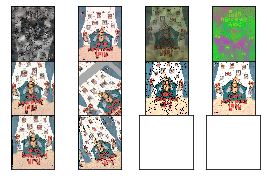

In [19]:
print("val 이미지폴더 보기")
plotCurrentFolderImages('D:/MyProject/PyTorch/InterBookRec/datas/mylocaltarget/val/7734_1', 4)

In [15]:
print("test 이미지폴더 보기")
#plotCurrentFolderImages('D:/MyProject/PyTorch/InterBookRec/datas/mylocaltarget/test/7734_1', 4)

test 이미지폴더 보기
